In [44]:
import sys
import os

# Get the current working directory (where the notebook is located)
curr_dir = os.getcwd()


# Add the project root to the system path
project_root = os.path.abspath(os.path.join(curr_dir, '..'))
sys.path.append(project_root)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import matplotlib.pyplot as plt
from tueplots import bundles
import src.BikeDataPlotter as BikePlotter
import src.EventsDataPlotter as EventsPlotter
import src.Colortheme as ct
import matplotlib.dates as mdates

import scipy.stats as stats
import pandas as pd
import numpy as np

from src.LoadEventsData import EventsData;
from src.LoadEcoCounterData import EcoCounterData as BikeData;
from src.LoadFuelData import FuelData

In [45]:
bd = BikeData()
ed = EventsData()

In [46]:
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.framealpha'] = 0.8
plt.rcParams.update({"figure.dpi": 200})
StYLE_4_SUBS = BikePlotter.FIGURE_STYLE[4]

In [47]:
# load eco counter data
bike_data = bd.get_hourly_data()

The fuel data is constructed from the following gas stations located in a 3km radius from the Tübingen citycenter:

Esso, Westbahnhofstraße 8, 72070

JET, Wilhelmstraße 101, 72074

Total, Rheinlandstraße 28, 72070

ARAL, Reutlinger Straße 72, 72072

JET, Europastr 57, 72072

STAR, Bebenhäuser Straße 7-9, 72074

ESSO, Bebenhäuser Straße 8, 72074

OMV, Waldhäuser Str 122, 72076


The prices are hourly averaged over all gas stations. The prices are in €/l.

In [48]:
# load fuel data
fd = FuelData()
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
fuel_data = fd.get_df(years=years)

## Correlation of fuel price and eco counter data
The goal is to find out, if significant changes in fuel price have an influence on the overall number of cyclists recorded by the Eco Counter in Tübingen.

### Data preparation

First the eco counter data for the "Steinlach" and "Fahrradtunnel" are extracted. We take the mean of the two counters to take into account that the counters are not recording the same amount of cyclists and that one counter can be broken for a certain time.

We will not look at the "Hirschau" counter, because earlier analysis showed that the data is different from the two counters located in the city center.

Then we merge the data with the fuel price data. To create one dataframe with all the data used for further analysis.

In [49]:
bike_df = bike_data[bike_data["counter_site_id"].isin([100003358, 100003359])]
bike_df = bike_df.groupby(['iso_timestamp'])['zählstand'].mean().reset_index()
bike_df.head(2)

,iso_timestamp,zählstand
0,2014-01-01 01:00:00+01:00,10.25
1,2014-01-01 02:00:00+01:00,17.75


In [50]:
# merge to get data that all counters have in common
df_data = fuel_data.merge(bike_df, on='iso_timestamp', how='inner')
df_data.head(2)

,iso_timestamp,diesel,benzin,zählstand
0,2015-01-01 00:00:00+00:00,1.222333,1.343444,3.75
1,2015-01-01 01:00:00+00:00,1.226500,1.348167,5.50


### Calculate the pearson correlation coefficient
We calculate the pearson correlation coefficient for the fuel price and the number of cyclists. This is done to find out if there is a correlation between the two variables.

We will also timeshift the cyclist data by upto 2 weeks to find out if there is a delayed effect of the fuel price on the number of cyclists.

In [51]:
# calculate the pearson correlation coefficient for different time timeshifts anf print the timeshift with the highest correlation
timeshifts = np.arange(1, 14)
corr = [stats.pearsonr(df_data['zählstand'][ts:], df_data['benzin'][:-ts])[0] for ts in timeshifts]
print("Maximal pearson correlation coefficient: ", np.max(corr))
print("Observed at timeshift: ", np.argmax(corr))

Maximal pearson correlation coefficient:  0.17014949617898123
Observed at timeshift:  9


Since there is very weak correlation between the fuel price and the number of cyclists when using hourly data, we will resample the data to a larger time interval. 

Fuel prices are not expected to change significant on a daily basis, so we will use a 2 week interval.

For the fuel prices we use the mean of the two weeks, for the number of cyclists we use the sum of the two weeks.

In [52]:
df_data_2w = df_data.set_index('iso_timestamp').resample('2W').agg({'zählstand': 'sum', 'benzin': 'mean', 'diesel': 'mean'}).reset_index()
timeshifts = np.arange(1, 4)
corr = [stats.pearsonr(df_data_2w['zählstand'][ts:], df_data_2w['benzin'][:-ts])[0] for ts in timeshifts]
print("Maximal pearson correlation coefficient: ", np.max(corr))
print("Observed at timeshift: ", np.argmax(corr))

Maximal pearson correlation coefficient:  0.3430232463910306
Observed at timeshift:  0


A weak correlation can be seen for the timeshifted data.

This indicates that there could be an effect of the fuel price on the number of cyclists.

Further analysis is needed to find out if this is true.

### Decompose the cyclist data into trend, seasonal and residual

We will decompose the cyclist data into trend, seasonal and residual to substract out any seasonal effects and calculate the correlation again.

We want to find out with what part of the data the fuel price is correlated.

For the decomposition of resampled 2 week data, we use the seasonal_decompose function from the statsmodels library. With a period of 26 weeks.

In [53]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [54]:
dec_bike = seasonal_decompose(df_data_2w.set_index('iso_timestamp')['zählstand'], model='additive', period=26, two_sided=False)
dec_bike_elems = [dec_bike.observed, dec_bike.trend, dec_bike.seasonal, dec_bike.resid]
decomp_bike_index = ["Mean Count per two Weeks", "Trend by Yearly Mean", "Seasonal Component", "Residuals"]

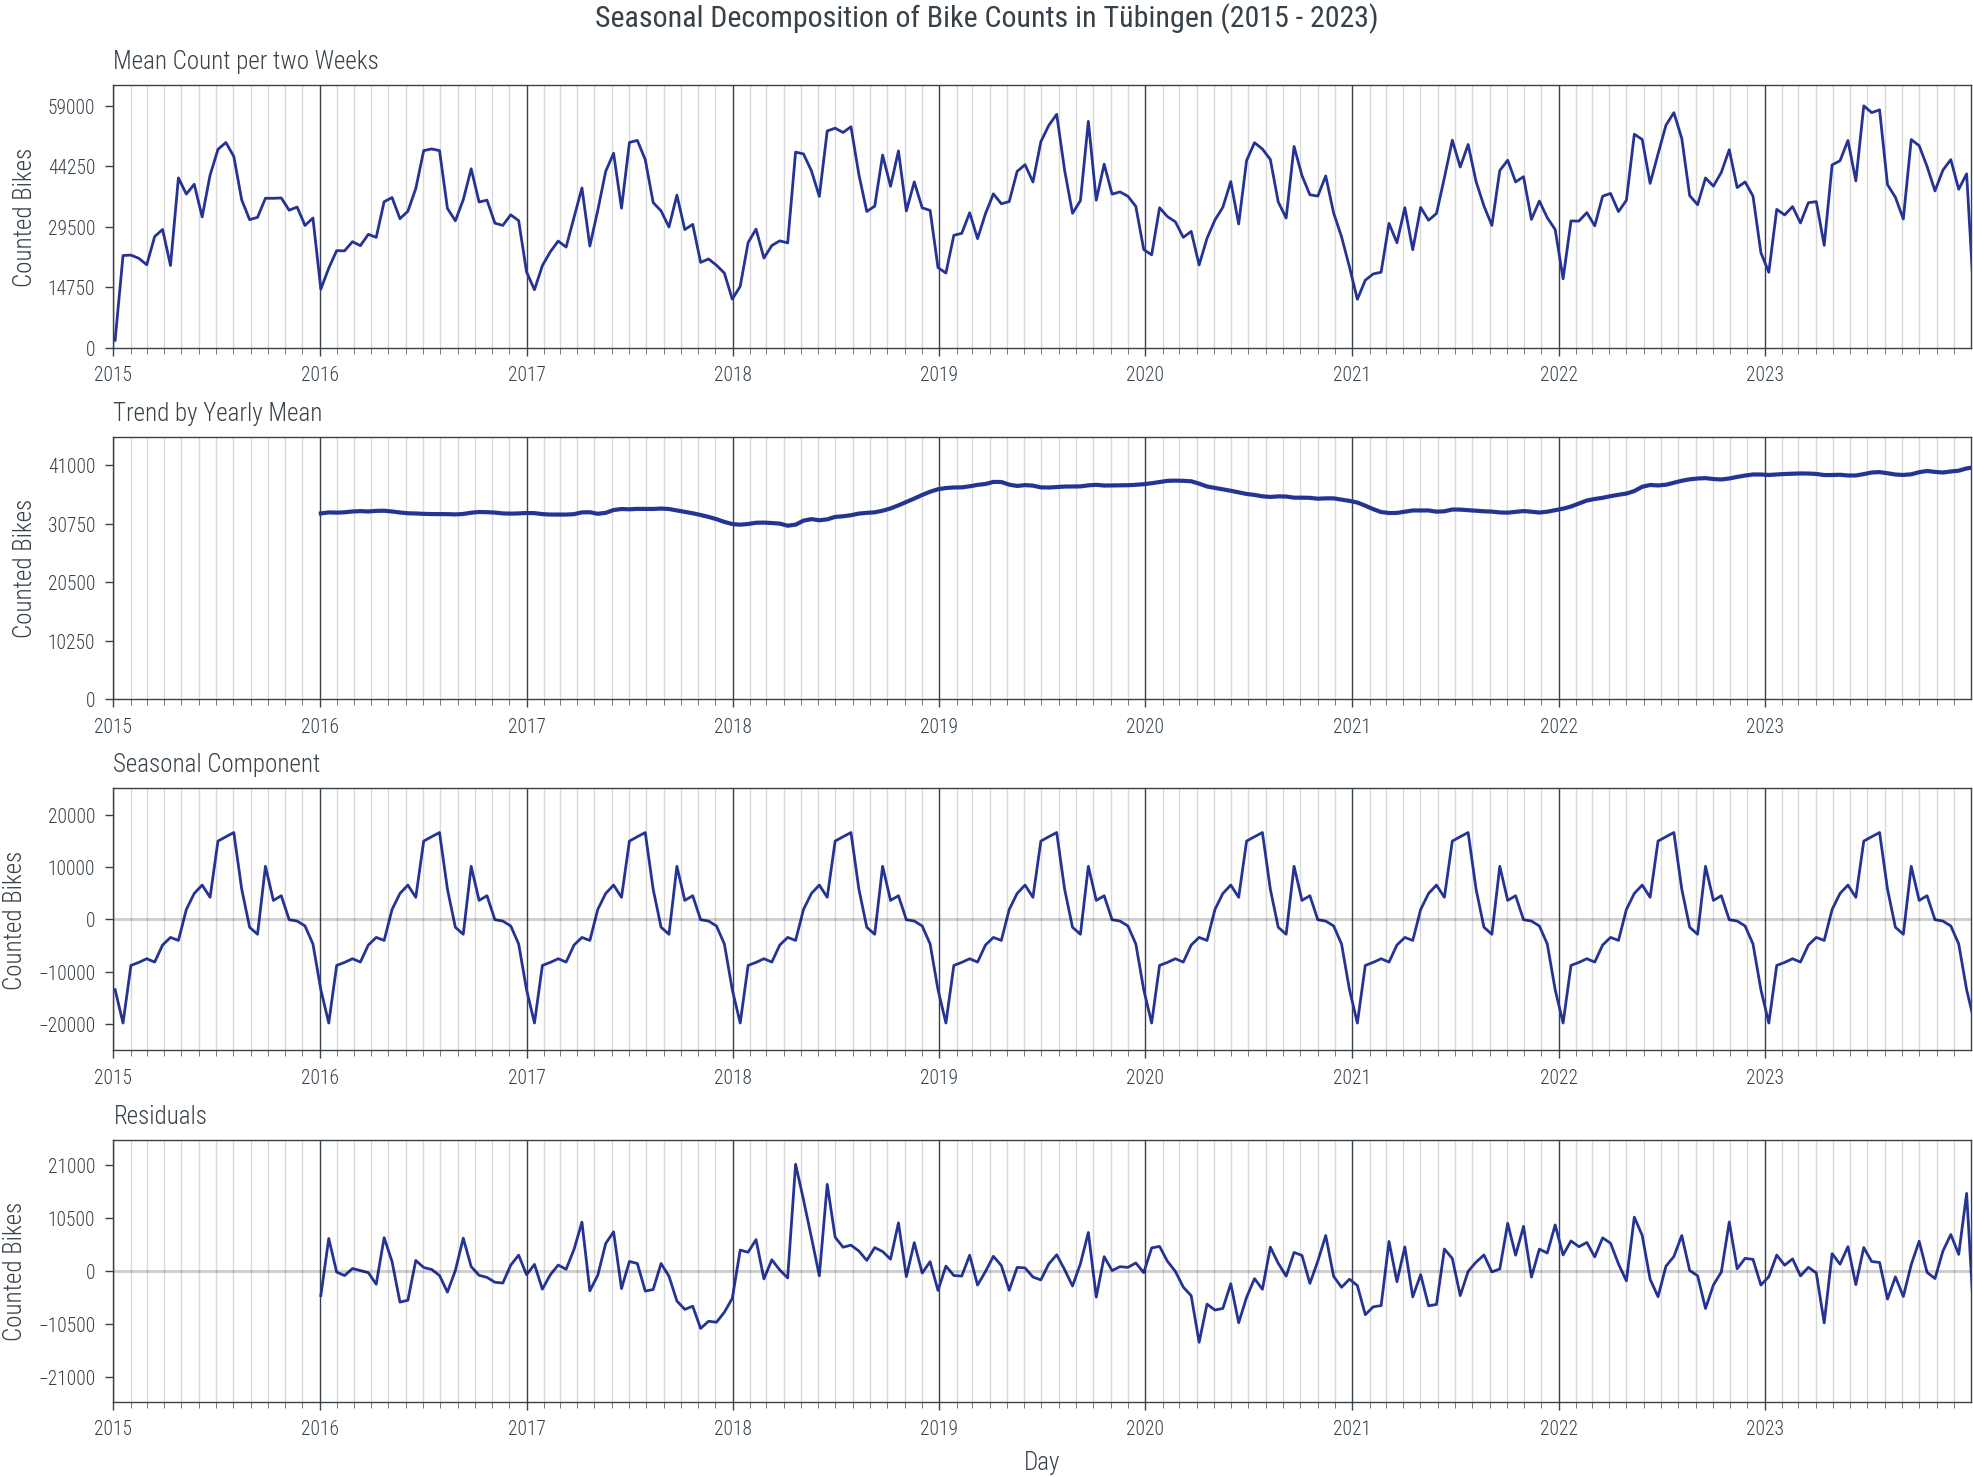

In [55]:
plt.rcParams.update(StYLE_4_SUBS)
fig, ax = plt.subplots(4, 1)
fig.suptitle(f"Seasonal Decomposition of Bike Counts in Tübingen (2015 - 2023)")
show_window = [pd.Timestamp(f"2015-01-01").date(), pd.Timestamp(f"2023-12-31").date()]
for i, elem in enumerate(dec_bike_elems):
    ax[i].plot(
        df_data_2w['iso_timestamp'],
        elem,
        color=ct.PRIMARY_COLORS[0],
        lw=BikePlotter.DECOMP_STYLE["lw"][i]
    )
    ax[i].set_ylabel('Counted Bikes')
    ax[i].set_xlim(show_window)
    ax[i].set_title(f"{decomp_bike_index[i]}", loc="left")
    ax[i].xaxis.set_minor_locator(mdates.MonthLocator())
    if i<2:
        ylims = (0, round(dec_bike_elems[i].max(),-3))
        y_offset = 5000
        ax[i].set_ylim(ylims[0], ylims[1]+y_offset)
        ax[i].set_yticks(np.linspace(ylims[0], ylims[1], 5))
    else:
        ax[i].axhline(0, color="black", alpha=0.2, lw=1)
        mag = -3
        y_offset = 5000
        abs_max = abs(round(max(elem.max(), elem.min(), key=abs),mag))
        ylims = (-abs_max, abs_max)
        ax[i].set_ylim(ylims[0]-y_offset, ylims[1]+y_offset)
        ax[i].set_yticks(np.linspace(ylims[0], ylims[1], 5))
    ax[i].grid(axis="x", which="major", ls="-", alpha=1)
    ax[i].grid(axis="x", which="minor", ls="-")
ax[-1].set_xlabel(BikePlotter.DECOMP_STYLE["xlabel"])
plt.show()

#### Correlation of decomposed bike data and fuel price

In [56]:
# calculate correlation coefficient for the trend, seasonality and residuals
timeshifts = np.arange(1, 4)
corr_trend = [stats.pearsonr(dec_bike.trend.dropna()[ts:], df_data_2w[df_data_2w['iso_timestamp'].isin(dec_bike.trend.dropna().index)]['benzin'][:-ts])[0] for ts in timeshifts]
corr_seasonal = [stats.pearsonr(dec_bike.seasonal.dropna()[ts:], df_data_2w[df_data_2w['iso_timestamp'].isin(dec_bike.seasonal.dropna().index)]['benzin'][:-ts])[0] for ts in timeshifts]
corr_residual = [stats.pearsonr(dec_bike.resid.dropna()[ts:], df_data_2w[df_data_2w['iso_timestamp'].isin(dec_bike.resid.dropna().index)]['benzin'][:-ts])[0] for ts in timeshifts]

print("Maximal pearson correlation coefficient for trend: ", np.max(corr_trend), " at timeshift: ", np.argmax(corr_trend))
print("Maximal pearson correlation coefficient for seasonal: ", np.max(corr_seasonal), " at timeshift: ", np.argmax(corr_seasonal))
print("Maximal pearson correlation coefficient for residual: ", np.max(corr_residual), " at timeshift: ", np.argmax(corr_residual))


Maximal pearson correlation coefficient for trend:  0.6057059861344037  at timeshift:  2
Maximal pearson correlation coefficient for seasonal:  0.10911090412946027  at timeshift:  0
Maximal pearson correlation coefficient for residual:  0.19960387556244813  at timeshift:  0


Looking at the correlation coefficients for the bike trend, seasonal and residual data to the fuel price, we can see that the correlation is mainly caused by the strong correlation of the trend data.
We can not make any conclusions about the seasonal and residual data, because the correlation is very weak not significant.

### Decompose the fuel price data into trend, seasonal and residual

In [57]:
dec_fuel = seasonal_decompose(df_data_2w.set_index('iso_timestamp')['benzin'], model='additive', period=26, two_sided=False)
dec_fuel_elems = [dec_fuel.observed, dec_fuel.trend, dec_fuel.seasonal, dec_fuel.resid]
dec_fuel_index = ["Mean Price per two Weeks", "Trend by Yearly Mean", "Seasonal Component", "Residuals"]

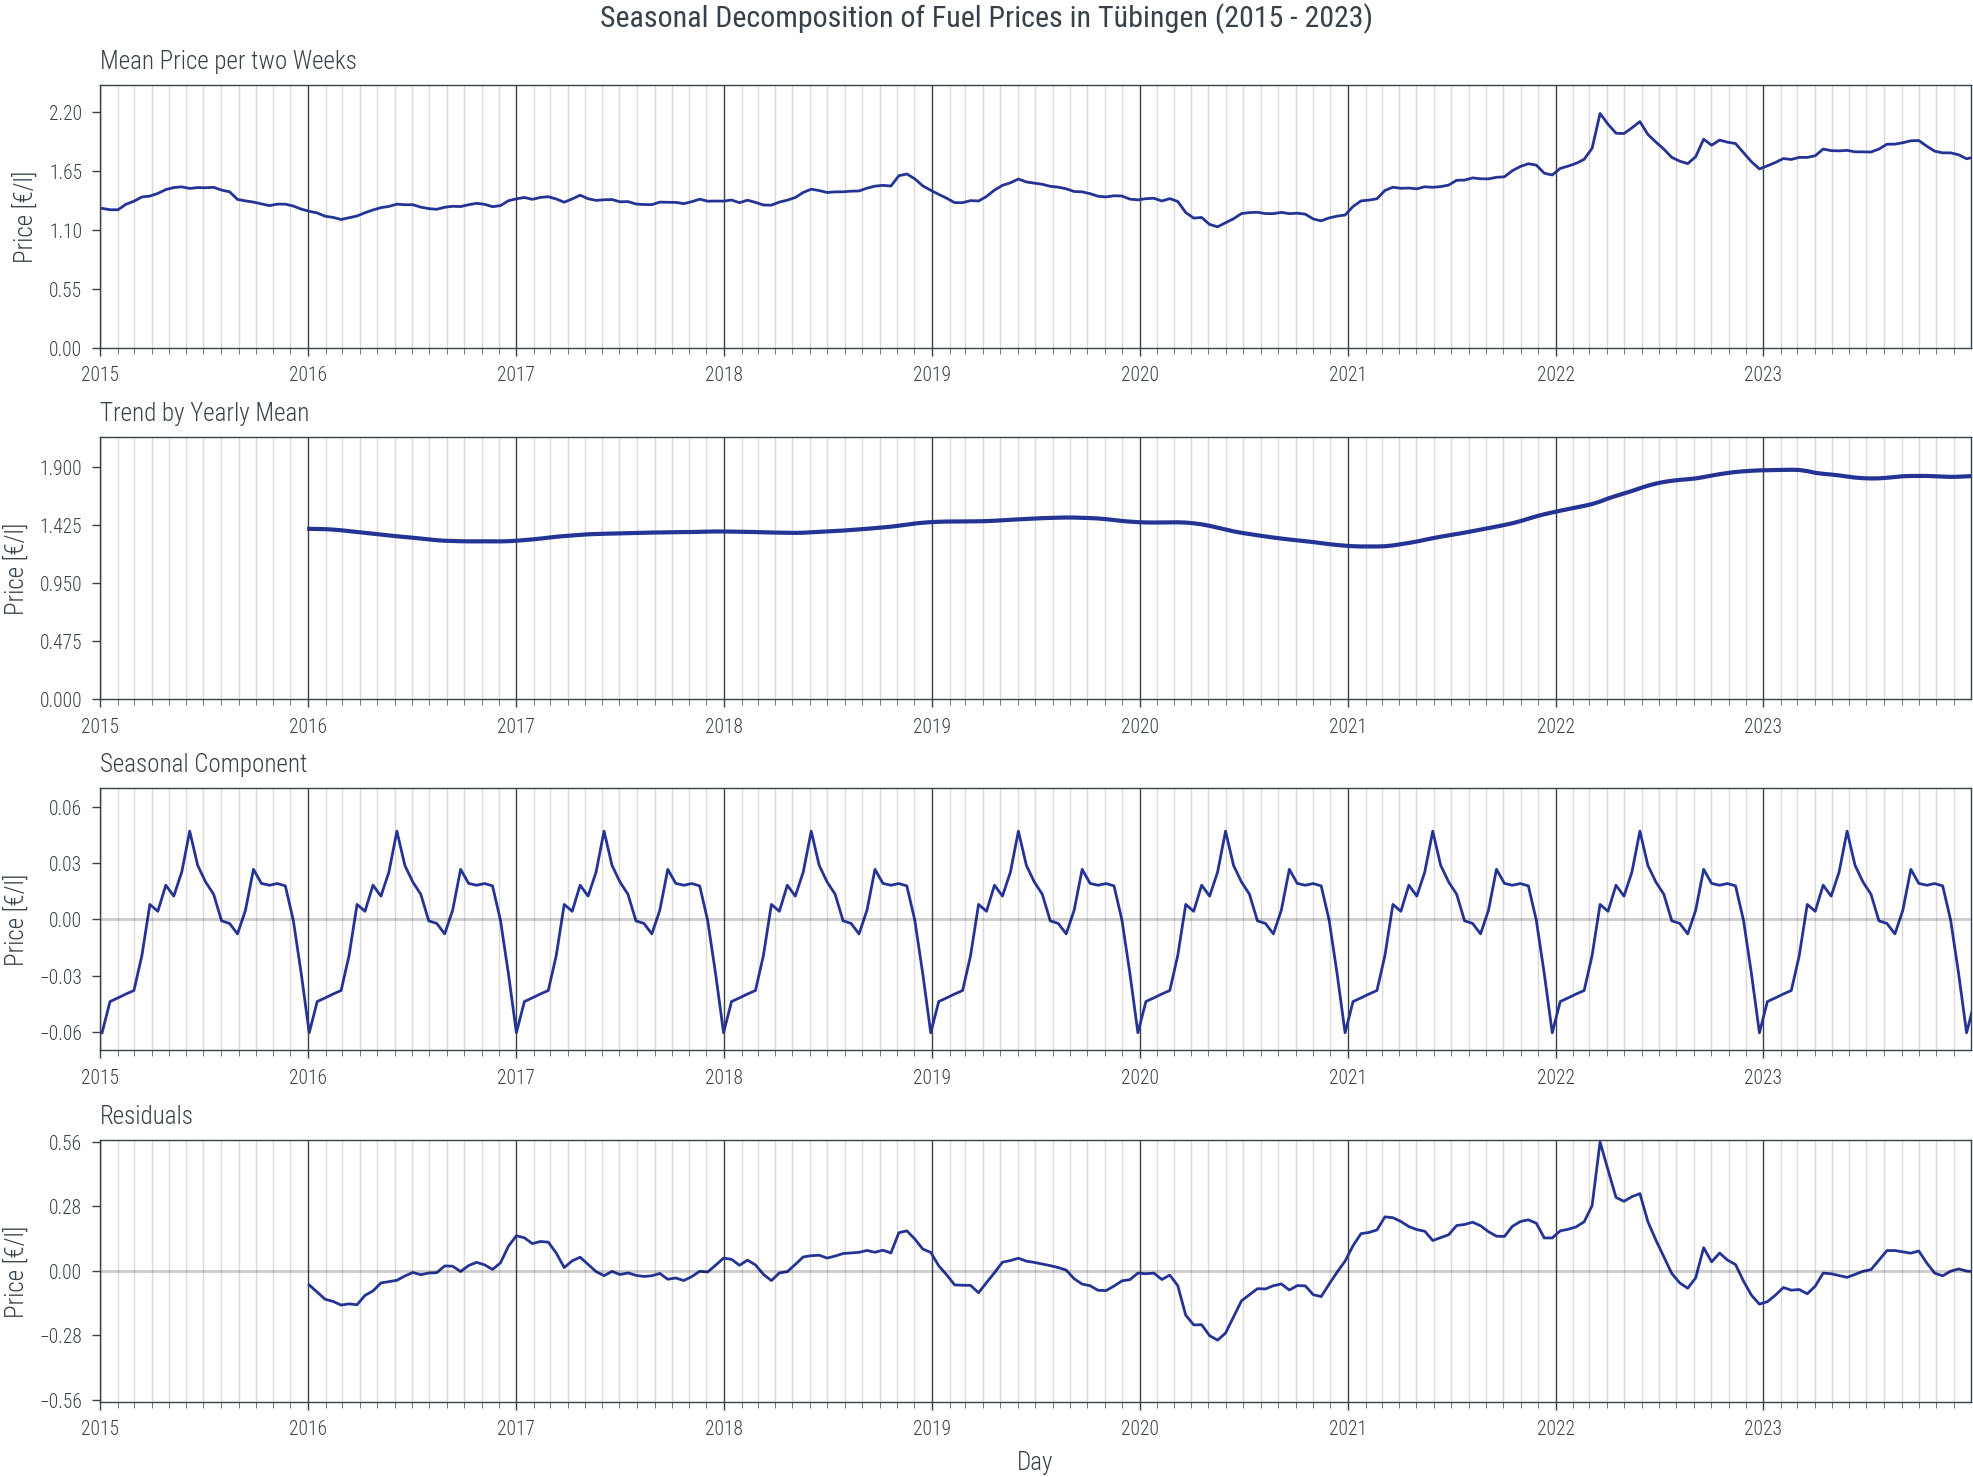

In [58]:
plt.rcParams.update(StYLE_4_SUBS)
fig, ax = plt.subplots(4, 1)
fig.suptitle(f"Seasonal Decomposition of Fuel Prices in Tübingen (2015 - 2023)")
show_window = [pd.Timestamp(f"2015-01-01").date(), pd.Timestamp(f"2023-12-31").date()]
for i, elem in enumerate(dec_fuel_elems):
    ax[i].plot(
        df_data_2w['iso_timestamp'],
        elem,
        color=ct.PRIMARY_COLORS[0],
        lw=BikePlotter.DECOMP_STYLE["lw"][i]
    )
    ax[i].set_ylabel('Price [€/l]')
    ax[i].set_xlim(show_window)
    ax[i].set_title(f"{dec_fuel_index[i]}", loc="left")
    ax[i].xaxis.set_minor_locator(mdates.MonthLocator())
    if i<2:
        ylims = (0, round(dec_fuel_elems[i].max(),1))
        y_offset = 0.25
        ax[i].set_ylim(round(ylims[0],2), round(ylims[1]+y_offset, 2))
        ax[i].set_yticks(np.linspace(ylims[0], ylims[1], 5))
    else:
        ax[i].axhline(0, color="black", alpha=0.2, lw=1)
        mag = 2
        y_offset = 0.01
        abs_max = abs(round(max(elem.max(), elem.min(), key=abs),mag))
        ylims = (-abs_max, abs_max)
        ax[i].set_ylim(ylims[0]-y_offset, ylims[1]+y_offset)
        ax[i].set_yticks(np.linspace(ylims[0], ylims[1], 5))
    ax[i].grid(axis="x", which="major", ls="-", alpha=1)
    ax[i].grid(axis="x", which="minor", ls="-")
ax[-1].set_xlabel(BikePlotter.DECOMP_STYLE["xlabel"])
plt.show()

#### Correlation of decomposed fuel price data and decomposed bike data

In [59]:
# calculate correlation coefficient for the trend, seasonality and residuals
timeshifts = np.arange(1, 4)
corr_trend = [stats.pearsonr(dec_bike.trend.dropna()[ts:], dec_fuel.trend.dropna()[:-ts])[0] for ts in timeshifts]
corr_seasonal = [stats.pearsonr(dec_bike.seasonal.dropna()[ts:], dec_fuel.seasonal.dropna()[:-ts])[0] for ts in timeshifts]
corr_residual = [stats.pearsonr(dec_bike.resid.dropna()[ts:], dec_fuel.resid.dropna()[:-ts])[0] for ts in timeshifts]

print("Maximal pearson correlation coefficient for trend: ", np.max(corr_trend), " at timeshifts: ", np.argmax(corr_trend))
print("Maximal pearson correlation coefficient for seasonal: ", np.max(corr_seasonal), " at timeshifts: ", np.argmax(corr_seasonal))
print("Maximal pearson correlation coefficient for residual: ", np.max(corr_residual), " at timeshifts: ", np.argmax(corr_residual))

Maximal pearson correlation coefficient for trend:  0.8206017393425881  at timeshifts:  2
Maximal pearson correlation coefficient for seasonal:  0.777241042798273  at timeshifts:  0
Maximal pearson correlation coefficient for residual:  0.24455305912304662  at timeshifts:  2


### Intermediate results
Since we were only able to find a correlation between the fuel price and the trend data of the number of cyclists which can have many different reasons and we can not make any conclusions about the seasonal and residual data, we can not say that there is a significant effect of the fuel price on the number of cyclists.

We will now try a different approach of finding out if there is a correlation between the fuel price and the number of cyclists during period of significant fuel price increases.

### Extracting significant rises in fuel price

A signficant rise in fuel price is defined as a rise of 3 standard deviations above the mean of the weekly fuel price change rate.

In [60]:
def find_and_color_significant_periods(price_series, change_series, significant_change):
    """
    Identify periods where the price starts changing significantly and returns to the level before the change,
    and determine if the change was an increase or a decrease.
    """
    periods = []
    in_significant_period = False
    start_price = None
    start_index = None
    period_type = None  # 'increase' or 'decrease'

    for date, (price, change) in enumerate(zip(price_series, change_series)):
        if not in_significant_period and abs(change) > significant_change:
            # Start of a significant period
            in_significant_period = True
            start_price = price
            start_index = date
            period_type = 'increase' if change > 0 else 'decrease'
        elif in_significant_period:
            # Check if price has returned to the level before the change
            if abs(price - start_price) < significant_change/3.5:
                # End of a significant period
                in_significant_period = False
                end_index = date
                periods.append((price_series.index[start_index], price_series.index[end_index], period_type))
    
    return periods

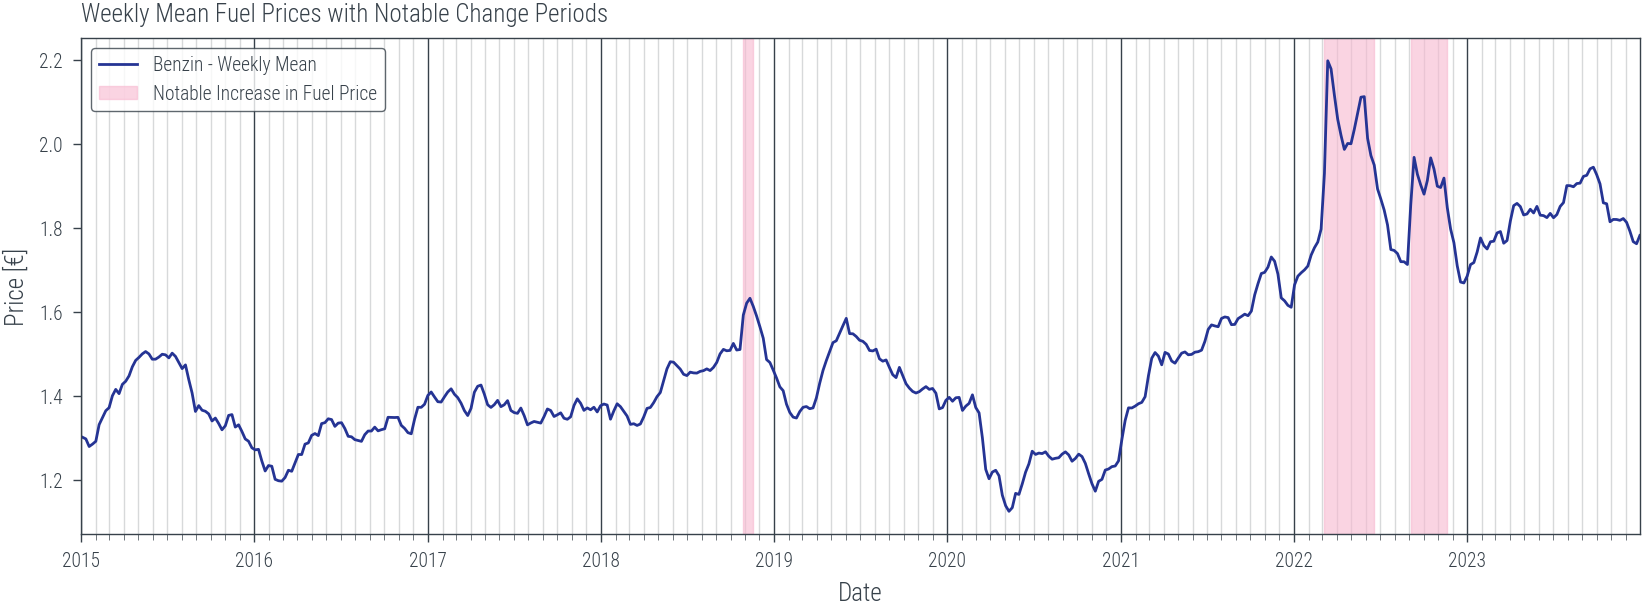

In [61]:
plt.rcParams.update(bundles.beamer_moml(rel_width=1.5,rel_height=1))
period = 1
sign_deviation = 3

df_data_1w = df_data.set_index('iso_timestamp').resample('W').agg({'zählstand': 'sum', 'benzin': 'mean', 'diesel': 'mean'})
# Calculating the rolling change for both benzin and diesel
df_data_1w['benzin_change'] = df_data_1w['benzin'].diff(periods=period)
df_data_1w['diesel_change'] = df_data_1w['diesel'].diff(periods=period)

# Defining a significant change as a change beyond 3 standard deviations from the mean change
std_benzin = df_data_1w['benzin_change'].std()
mean_benzin = df_data_1w['benzin_change'].mean()
significant_change_benzin = mean_benzin + std_benzin*sign_deviation

# Find significant periods with color coding for benzin and diesel
significant_periods_benzin = find_and_color_significant_periods(
    df_data_1w['benzin'], df_data_1w['benzin_change'], significant_change_benzin
)

# Plotting
fig, ax = plt.subplots(1)
plt.plot(df_data_1w.index, df_data_1w['benzin'], 
         label='Benzin - Weekly Mean', 
         linestyle='-',
         color=ct.PRIMARY_COLORS[0]
)

# Plotting significant periods for benzin
span_color = [ct.AREA_COLORS[1],ct.AREA_COLORS[2]]
selected_col = None
alph = 0.6
for start, end, period_type in significant_periods_benzin:
    selected_col = span_color[0] if period_type == 'increase' else span_color[1]
    plt.axvspan(start, end, color=selected_col, alpha=alph)
    

ax.set_title('Weekly Mean Fuel Prices with Notable Change Periods', loc="left")
ax.set_xlabel('Date')
ax.set_ylabel('Price [€]')
ax.set_xlim(show_window)
# add one itm to legend
ax.axvspan(None, None, color=selected_col, alpha=alph, label='Notable Increase in Fuel Price')
ax.legend()
ax.xaxis.set_minor_locator(mdates.MonthLocator())

ax.grid(axis="x", which="major", ls="-", alpha=1)
ax.grid(axis="x", which="minor", ls="-")
# plt.xticks(rotation=45)
plt.show()

After extracting the periods of significant fuel price rises, we can see that two of the periods start simultaneously with the start of the Ukraine war at the end of February 2022 and the end of the so called "Spritpreisbremse" at the end of August 2022.

We will now extract the cyclist data for these periods as well as for the same duration before and after the period.

For this analysis we will use daily data.

#### Extract data for periods of significant fuel price rises and label the data

In [62]:
# Function to label the data as 'before', 'during', or 'after'
def label_period_during_extraction(row, start, end):
    duration = end - start
    if start - duration <= row['iso_timestamp'] < start:
        return 'before'
    elif start <= row['iso_timestamp'] <= end:
        return 'during'
    elif end < row['iso_timestamp'] <= end + duration:
        return 'after'
    return 'other'

In [63]:
df_data_daily = df_data.set_index('iso_timestamp').resample('D').agg({'zählstand': 'sum', 'benzin': 'mean', 'diesel': 'mean'}).reset_index()
# Modified code to label data during extraction

# Initialize an empty DataFrame for extracted data
extracted_data_with_labels = pd.DataFrame()

# Process each time period and label data during extraction
for start, end, _ in significant_periods_benzin:
    # Duration of the period
    duration = end - start

    # Period before, during, and after
    start_before = start - duration
    end_after = end + duration

    # Extract and label data for the periods
    period_data = df_data_daily[(df_data_daily['iso_timestamp'] >= start_before) & (df_data_daily['iso_timestamp'] <= end_after)].copy()
    period_data['period'] = period_data.apply(lambda row: label_period_during_extraction(row, start, end), axis=1)
    
    # Concatenate the extracted data
    extracted_data_with_labels = pd.concat([extracted_data_with_labels, period_data])

# Reset index of the final dataframe
extracted_data_with_labels.reset_index(drop=True, inplace=True)

### Plot the mean and standard deviation for 2022 against the mean and standard deviation for the periods of extreme fuel price rises in 2022

If the fuel price has no effect on the number of cyclists, we would expect the number of cyclists to be the same during the periods of significant fuel price rises and the periods before and after.

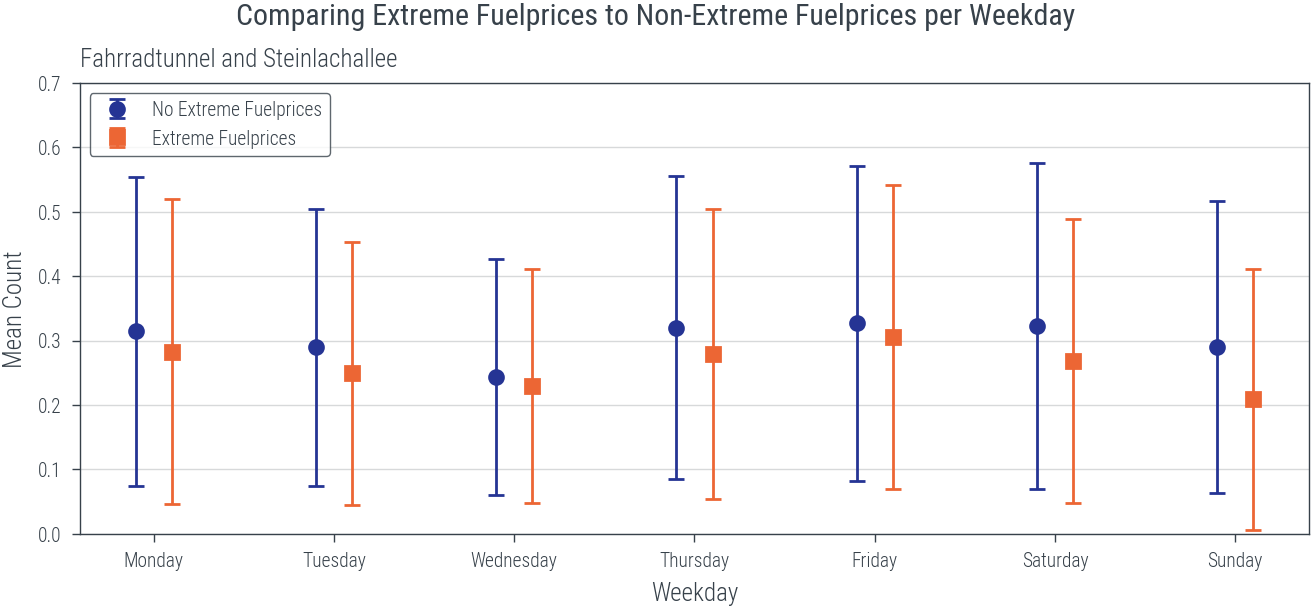

In [64]:
plt.rcParams.update(bundles.beamer_moml(rel_width=1.2, rel_height=1))

weekday_mapping = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
# Fahrradtunnel abd Steinlachallee
bike_df['weekday'] = bike_df['iso_timestamp'].dt.weekday
bike_df["zählstand"] = bike_df["zählstand"] / bike_df["zählstand"].max()

counter_names = ["Fahrradtunnel and Steinlachallee"]
#TODO: SettingWithCopyWarning dear lord
fig, ax = plt.subplots(1, 1)
for d in range(7):
    bike_df_wd = bike_df[bike_df["weekday"] == d].copy()
    bike_df_wd["zählstand"] /= bike_df_wd["zählstand"].max()
    df_bike_extreme_fuelprice = bike_df_wd[(bike_df_wd["iso_timestamp"].dt.date.isin(extracted_data_with_labels[extracted_data_with_labels['period'] == 'during']['iso_timestamp'].dt.date))
                                           & (bike_df_wd["iso_timestamp"].dt.year == 2022)]
    df_bike_no_extreme_fuelprice = bike_df_wd[(bike_df_wd["iso_timestamp"].dt.date.isin(extracted_data_with_labels[extracted_data_with_labels['period'] == 'before']['iso_timestamp'].dt.date))
                                              & (bike_df_wd["iso_timestamp"].dt.date.isin(extracted_data_with_labels[extracted_data_with_labels['period'] == 'after']['iso_timestamp'].dt.date))
                                              & (bike_df_wd["iso_timestamp"].dt.year == 2022)]

    ax.errorbar(
        x=d-0.1,
        y=df_bike_no_extreme_fuelprice[df_bike_no_extreme_fuelprice["weekday"] == d]["zählstand"].mean(),
        yerr=df_bike_no_extreme_fuelprice[df_bike_no_extreme_fuelprice["weekday"] == d]["zählstand"].std(),
        capsize=3,
        fmt="o",
        ms=5,
        color=ct.PRIMARY_COLORS[0],
        label="No Extreme Fuelprices" if d == 0 else "_nolabel_"
    )
    ax.errorbar(
        x=d+0.1,
        y=df_bike_extreme_fuelprice[df_bike_extreme_fuelprice["weekday"] == d]["zählstand"].mean(),
        yerr=df_bike_extreme_fuelprice[df_bike_extreme_fuelprice["weekday"] == d]["zählstand"].std(),
        capsize=3,
        fmt="s",
        ms=5,
        color=ct.PRIMARY_COLORS[1],
        label="Extreme Fuelprices" if d == 0 else "_nolabel_"
    )
    ax.set_xticks(range(7))
    ax.set_xticklabels(weekday_mapping)
    ax.set_ylim(bottom=0)
    ax.set_title(counter_names[0], loc="left")
    ax.grid(axis="y")
    ax.set_ylim(0, .7)
ax.set_ylabel("Mean Count")
ax.set_xlabel("Weekday")
plt.suptitle("Comparing Extreme Fuelprices to Non-Extreme Fuelprices per Weekday")
ax.legend(loc="upper left")
plt.show()

A rise in the mean number of cyclists can be seen on all weekdays. This indicates that there were more cyclists detected outside the periods of significant fuel price rises than during.

This disproves the hypothesis that a short term extreme increase in fuel prices lead to more cyclists.